In [ ]:
import numpy as np
import cv2
import os
from collections import namedtuple
from google.colab import drive
from google.colab.patches import cv2_imshow


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CVA2')


Mounted at /content/drive


In [ ]:
def extract(path, x, y):
  folders = os.listdir(path)

  for folder in folders:
    folder_path = os.path.join(path, folder)

    if os.path.isdir(folder_path):

      image_files = os.listdir(folder_path)
      for image_file in image_files:
        # Read
        image_path = os.path.join(folder_path, image_file)
        if os.path.isfile(image_path):
          try:
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::]
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
            # Add
            x.append(img)
            if folder == 'aiart':
              y.append(0)
            else:
              y.append(1)
          except:
            pass

  return x, y


In [ ]:
def extend(path, x, y):
  folders = os.listdir(path)
  e = 0
  for folder in folders:
    folder_path = os.path.join(path, folder)

    if os.path.isdir(folder_path):

      image_files = os.listdir(folder_path)
      for image_file in image_files:
        # Read
        image_path = os.path.join(folder_path, image_file)
        if os.path.isfile(image_path):
          try:
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
            # Add
            x.append(img)
            if folder == 'aiart':
              y.append(0)
            else:
              y.append(1)
          except:
            print("Error reading the image:", image_path)
            e += 1
            if e == 10:
              print("Early exit because of errors")
              break

  return x, y

# Task 1: Dataset

## Initial Dataset

In [ ]:
x_test, y_test = extract('original', [], [])
# x_train, y_train = extract('original', [], [])

In [ ]:
def count(data):
  counter = {}

  for e in data:
    if e in counter:
      counter[e] += 1
    else:
      counter[e] = 1

  return counter


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors


def plot_h(data):

  labels = list(data.keys())
  counts = list(data.values())
  print(labels)
  print(counts)

  plt.figure()
  plt.figure(figsize=(8, 8))

  col = plt.cm.viridis
  plt.bar(labels, counts, color=col((np.arange(len(labels)) / (len(labels) - 1))))  # Category labels
  plt.title('Dataset')

  plt.xticks(rotation=0)  # Rotate x-axis labels for readability if needed
  plt.tight_layout()
  plt.show()


['aiart', 'real']
[17, 17]


<Figure size 640x480 with 0 Axes>

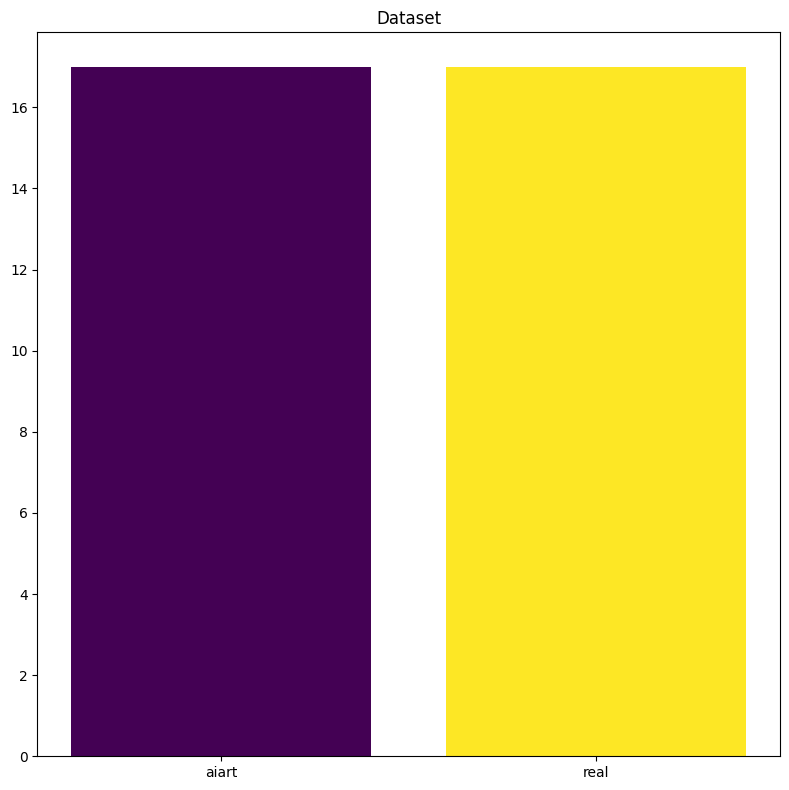

In [ ]:
c = count(y_train)
plot_h(c)

## Extend the Dataset

In [ ]:
# x_train, y_train = extract('dataset/train', x_train, y_train)
x_train, y_train = extract('dataset/train', [], [])
# x_test, y_test = extract('dataset/test', [], [])
x_test, y_test = extract('dataset/test', x_test, y_test)

['aiart', 'real']
[37, 704]


<Figure size 640x480 with 0 Axes>

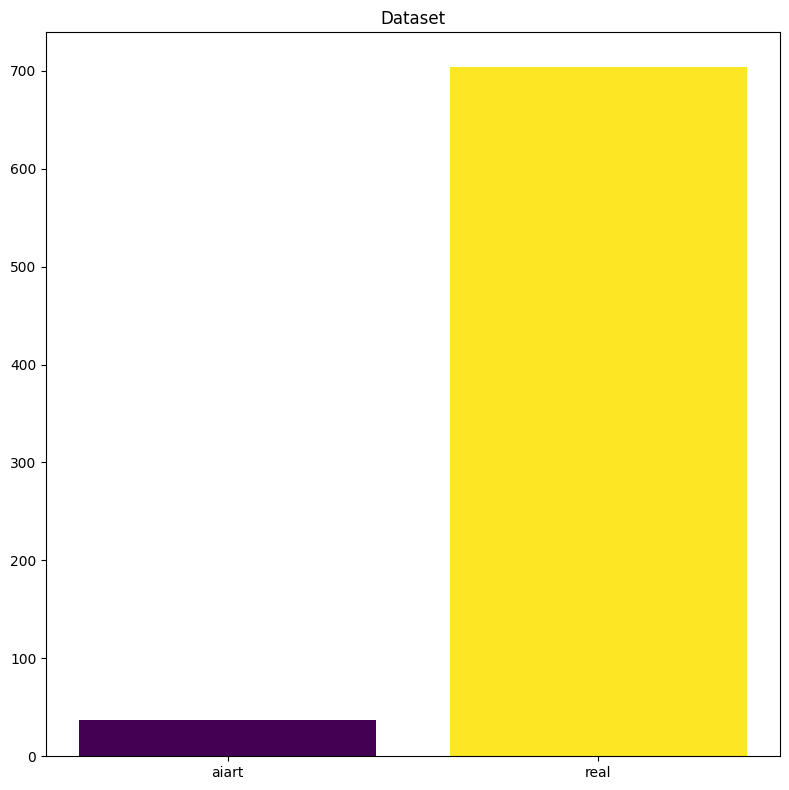

In [ ]:
c = count(y_train)
plot_h(c)

['aiart', 'real']
[7, 159]


<Figure size 640x480 with 0 Axes>

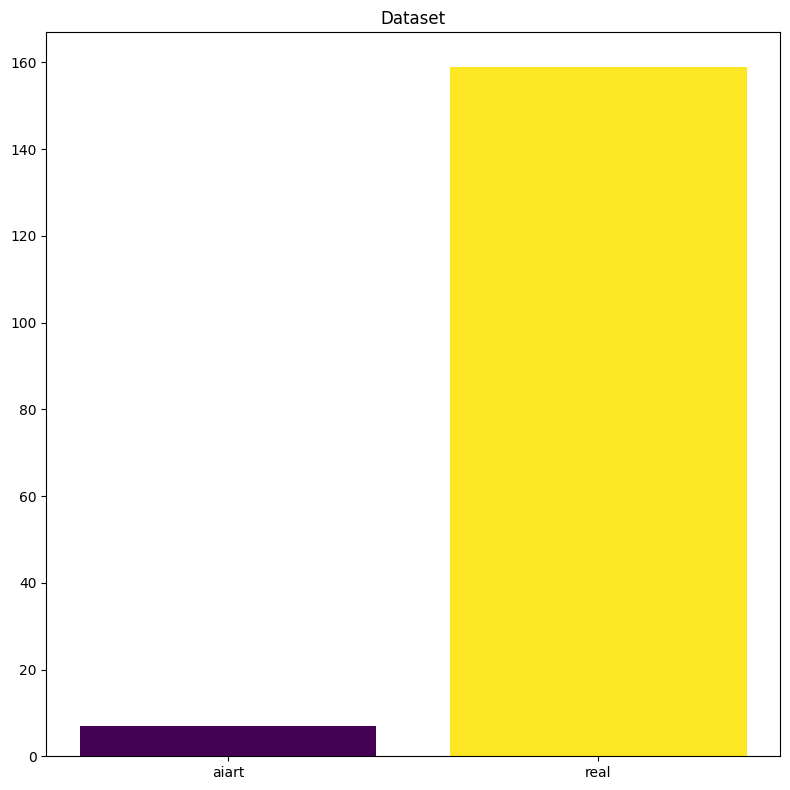

In [ ]:
c = count(y_test)
plot_h(c)

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def augment(n, src, dst):

  augmentator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    vertical_flip=True,
    channel_shift_range=0.1,
  )


  # Get list of image paths in the source folder
  image_paths = [os.path.join(src, filename) for filename in os.listdir(src)
                if filename.lower().endswith((".jpg", ".jpeg", ".png"))]

  # Loop through each image path
  for image_path in image_paths:
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::]
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # Reshape for the data generator
    img = img.reshape((1,) + img.shape)

    # Generate and save augmented images
    j = 0
    for batch in augmentator.flow(img, batch_size=1, save_to_dir=dst, save_format='jpeg', save_prefix='generated'):
      j += 1
      if j >= n:
        break



In [ ]:
# augment(1, 'dataset/test/aiart', 'trial') # Generate 1 images for each image
#! DONE augment(1, 'dataset/train/real', 'dataset/augmented/train/real') # Generate 1 images for each image
#! DONE augment(38, 'dataset/train/aiart', 'dataset/augmented/train/aiart') # Generate 38 images for each image

In [ ]:
# Add the augmented data
x_train, y_train = extend('dataset/augmented/train', x_train, y_train)

(2062, 256, 256, 3)


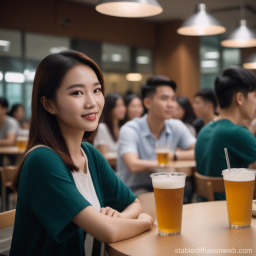

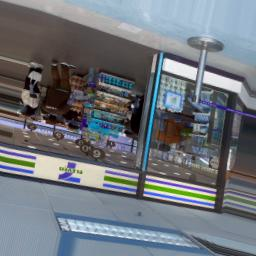

In [ ]:
print(np.array(x_train).shape)
cv2_imshow(x_train[0])
cv2_imshow(x_train[-1])

['aiart', 'real']
[893, 1169]


<Figure size 640x480 with 0 Axes>

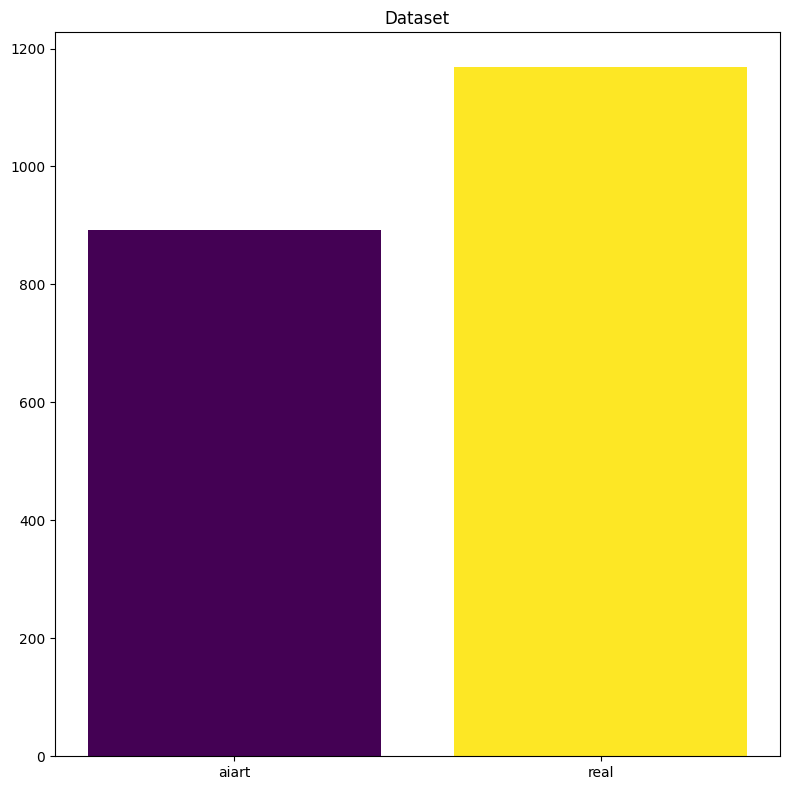

In [ ]:
c = count(y_train)
plot_h(c)

In [ ]:
def visualize_augmented(x):
  images = x[-15:]

  # Define the number of rows and columns for the subplot
  num_rows = 3
  num_cols = 5

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 3))

  for i, img in enumerate(images):
    img = img / 255.0

    # Plot the image on the corresponding subplot
    axes.flat[i].imshow(img)

    # Remove axes labels and ticks for a cleaner visualization (optional)
    axes.flat[i].axis('off')

  # Set a common title for all subplots (optional)
  fig.suptitle('Generated Data Augmentation Images', fontsize=12)

  # Show the plot
  plt.tight_layout()
  plt.show()

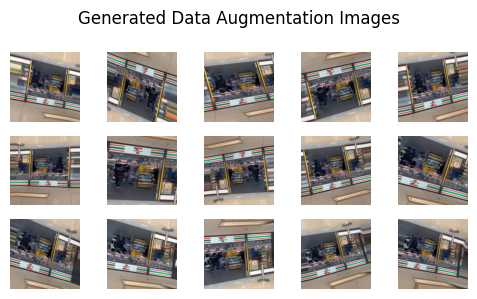

In [ ]:
visualize_augmented(x_train)

# Models

## MyCNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

image_shape = (256, 256, 3)

model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))  # Dropout for regularization

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Fully connected layer 2 (output layer)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 62, 62, 64)       

## Visualize the architecture

In [ ]:
from PIL import ImageFont
import visualkeras

visualkeras.layered_view(model, legend=True).show()
visualkeras.layered_view(model, to_file='architecture.png', legend=True) # write to disk

In [ ]:
npx_train = np.array(x_train)
npy_train = np.array(y_train)

In [ ]:
print(npx_train.shape)
print(npy_train.shape)

(1825, 256, 256, 3)
(1825,)


# Validation

In [ ]:
from sklearn.model_selection import train_test_split
npx_train, x_val, npy_train, y_val = train_test_split(npx_train, npy_train, test_size=0.1, random_state=42)

In [ ]:
# fit the keras model on the dataset
results = model.fit(npx_train, npy_train, epochs=15)

Epoch 1/15
58/58 [==============================] - 331s 6s/step - loss: 152.6380 - accuracy: 0.6071
Epoch 2/15
58/58 [==============================] - 322s 6s/step - loss: 0.4728 - accuracy: 0.7660
Epoch 3/15
58/58 [==============================] - 332s 6s/step - loss: 0.4252 - accuracy: 0.8104
Epoch 4/15
58/58 [==============================] - 322s 6s/step - loss: 0.3514 - accuracy: 0.8384
Epoch 5/15
58/58 [==============================] - 328s 6s/step - loss: 0.4053 - accuracy: 0.8433
Epoch 6/15
58/58 [==============================] - 319s 5s/step - loss: 0.3895 - accuracy: 0.8099
Epoch 7/15
58/58 [==============================] - 333s 6s/step - loss: 0.2737 - accuracy: 0.8789
Epoch 8/15
58/58 [==============================] - 320s 6s/step - loss: 0.2387 - accuracy: 0.9041
Epoch 9/15
58/58 [==============================] - 317s 5s/step - loss: 0.2634 - accuracy: 0.8964
Epoch 10/15
58/58 [==============================] - 304s 5s/step - loss: 0.1876 - accuracy: 0.9255
Epoch 1

In [ ]:
# Save the model
model.save('model-10cv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('model05cv.h5')

In [ ]:
# Plot training history
def plot_training_history(history):

  plt.figure(figsize=(10, 6))

  # Loss subplot
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.grid(True)

  # Accuracy subplot
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')
  plt.grid(True)

  # Legend for the entire figure
  plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1))  # Adjust legend position if needed

  plt.tight_layout()
  plt.show()

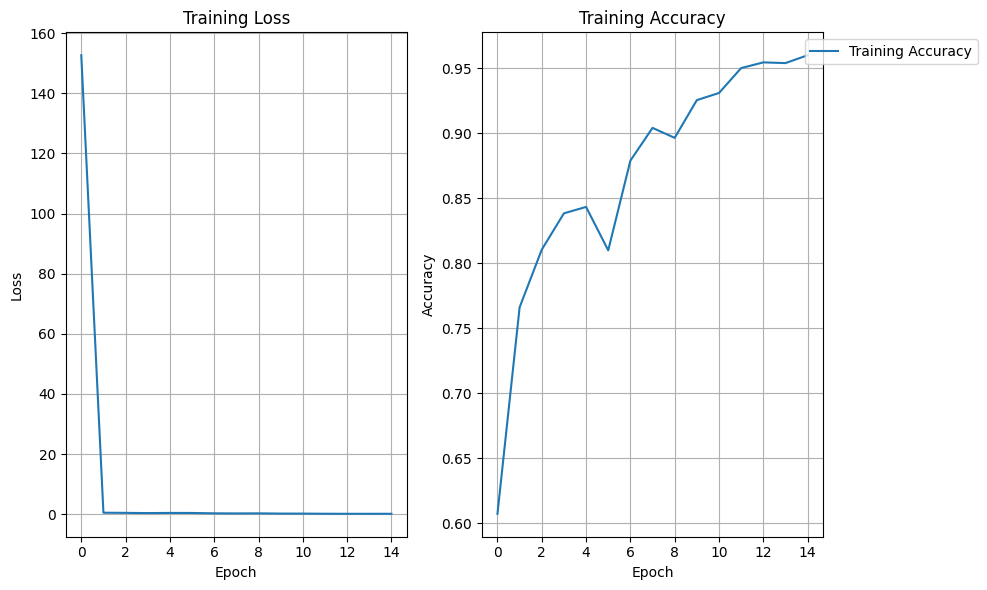

In [ ]:
plot_training_history(results.history)

In [ ]:
# evaluate the keras model on validation data
loss, accuracy = model.evaluate(x_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))

7/7 [==============================] - 65s 1s/step - loss: 0.1358 - accuracy: 0.9360
Accuracy: 93.60


# Test

In [ ]:
# x_test, y_test = extract('dataset/test', [], [])

In [ ]:
npx_test = np.array(x_test)
npy_test = np.array(y_test)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# predict on the test set
y_pred = model.predict(npx_test) # Returns probability
y_pred = np.round(y_pred)

# calculate accuracy.
accuracy = accuracy_score(npy_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


7/7 [==============================] - 11s 1s/step
Accuracy: 80.00%


In [ ]:
import tensorflow as tf
import keras

# With extended test data

# Load the model
# loaded_model = tf.keras.models.load_model('model-05cv.h5')
# predict on the test set
# y_pred = loaded_model.predict(npx_test) # Returns probability
# y_pred = np.round(y_pred)

# calculate accuracy.
# accuracy = accuracy_score(npy_test, y_pred)
# print(f'Accuracy: {accuracy * 100:.2f}%')

7/7 [==============================] - 9s 1s/step
Accuracy: 89.00%
